/tmp/ipykernel_280912/1156552151.py:4: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("trade_book.csv", parse_dates=['exch_tm'])


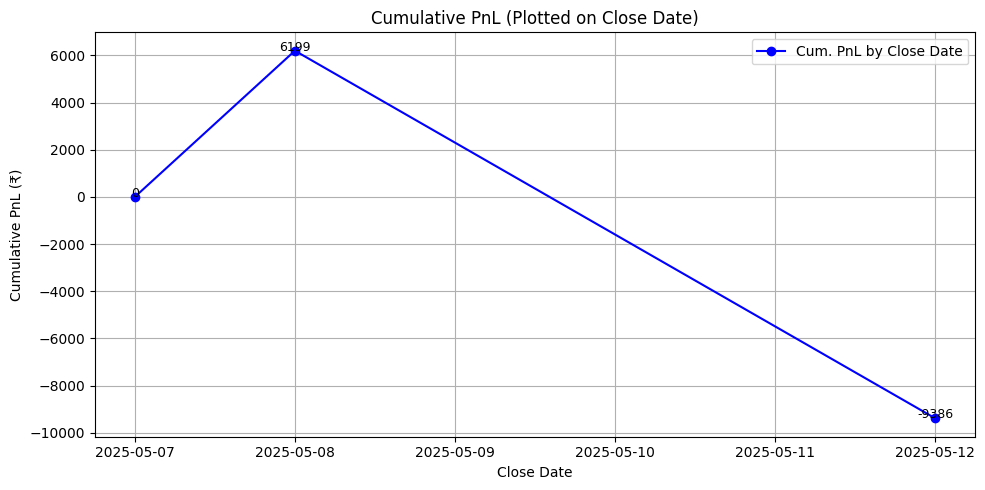

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("trade_book.csv", parse_dates=['exch_tm'])

#########################################################


df['exch_tm'] = pd.to_datetime(df['exch_tm'], format="%d-%m-%Y %H:%M:%S")

# --- Separate Buy and Sell Trades ---
buys = df[df['trantype'] == 'B'].copy().sort_values('exch_tm')
sells = df[df['trantype'] == 'S'].copy().sort_values('exch_tm')

# --- Match Trades by tsym and Close Them on the Later Date ---
matched_trades = []

for tsym in df['tsym'].unique():
    buy_trades = buys[buys['tsym'] == tsym].copy()
    sell_trades = sells[sells['tsym'] == tsym].copy()

    while not buy_trades.empty and not sell_trades.empty:
        buy = buy_trades.iloc[0]
        sell = sell_trades.iloc[0]
        qty = min(buy['flqty'], sell['flqty'])
        pnl = (sell['flprc'] - buy['flprc']) * qty

        close_time = max(buy['exch_tm'], sell['exch_tm'])  # ✅ Closing date is the later one

        matched_trades.append({
            'tsym': tsym,
            'close_time': close_time,
            'pnl': pnl
        })

        # Adjust remaining qty
        if buy['flqty'] > qty:
            buy_trades.iloc[0, buy_trades.columns.get_loc('flqty')] -= qty
        else:
            buy_trades = buy_trades.iloc[1:]
        if sell['flqty'] > qty:
            sell_trades.iloc[0, sell_trades.columns.get_loc('flqty')] -= qty
        else:
            sell_trades = sell_trades.iloc[1:]

# --- Build PnL by Close Date ---
matched_df = pd.DataFrame(matched_trades)
if matched_df.empty:
    print("No matched trades.")
else:
    matched_df['close_date'] = matched_df['close_time'].dt.date
    daily_pnl = matched_df.groupby('close_date')['pnl'].sum().reset_index()
    start_date = daily_pnl['close_date'].min()
    zero_row = pd.DataFrame([{'close_date': start_date - pd.Timedelta(days=1), 'pnl': 0, 'cum_pnl': 0}])
    daily_pnl = pd.concat([zero_row, daily_pnl], ignore_index=True)
    daily_pnl['cum_pnl'] = daily_pnl['pnl'].cumsum()

    # --- Plot Cumulative PnL at Each Close Date ---
    plt.figure(figsize=(10, 5))
    plt.plot(daily_pnl['close_date'], daily_pnl['cum_pnl'], marker='o', color='blue', label='Cum. PnL by Close Date')

    for i, row in daily_pnl.iterrows():
        plt.text(row['close_date'], row['cum_pnl'] + 5, f"{row['cum_pnl']:.0f}", ha='center', fontsize=9)

    plt.title("Cumulative PnL (Plotted on Close Date)")
    plt.xlabel("Close Date")
    plt.ylabel("Cumulative PnL (₹)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




In [ ]:
matched_df

,tsym,buy_time,sell_time,buy_price,sell_price,qty,pnl,cum_pnl,running_max,drawdown
0,NIFTY08MAY25P24200,2025-05-08 09:15:07,2025-04-20 09:15:07,5.20,179.22,75,13051.50,13051.50,13051.5,0.00
1,NIFTY08MAY25P23800,2025-04-20 09:15:07,2025-05-08 09:15:07,93.62,2.25,75,-6852.75,6198.75,13051.5,6852.75
2,NIFTY29MAY25C24800,2025-05-12 09:15:30,2025-05-09 10:27:25,179.20,117.00,75,-4665.00,1533.75,13051.5,11517.75
3,NIFTY29MAY25C24800,2025-05-12 09:15:30,2025-05-09 10:27:25,179.20,117.05,75,-4661.25,-3127.50,13051.5,16179.00
4,NIFTY29MAY25C24800,2025-05-12 09:15:30,2025-05-09 10:27:25,179.20,117.10,75,-4657.50,-7785.00,13051.5,20836.50
5,NIFTY29MAY25C24800,2025-05-12 09:15:30,2025-05-09 10:27:25,179.20,117.15,75,-4653.75,-12438.75,13051.5,25490.25
6,NIFTY29MAY25C25300,2025-05-09 10:27:23,2025-05-12 09:15:32,34.85,50.00,75,1136.25,-11302.50,13051.5,24354.00
7,NIFTY29MAY25C25300,2025-05-09 10:27:23,2025-05-12 09:15:32,34.85,49.20,75,1076.25,-10226.25,13051.5,23277.75
8,NIFTY29MAY25C25300,2025-05-09 10:27:23,2025-05-12 09:15:32,34.85,50.25,75,1155.00,-9071.25,13051.5,22122.75
9,NIFTY29MAY25C25300,2025-05-09 10:27:23,2025-05-12 09:15:32,34.85,50.35,75,1162.50,-7908.75,13051.5,20960.25
